In [1]:
import xarray as xr 
import os 
scratch = os.environ['SCRATCH']
ds = xr.open_dataset(f'{scratch}/batch_with_tos/1960_1_tos_included.nc')


In [2]:
tos_data = ds['tos'].isel(time=0)
el_nino_34 = tos_data.where(
    (tos_data.lat < 5) & (tos_data.lat > -5) & (tos_data.lon > 190) & (tos_data.lon < 240), drop=True
)

In [3]:
lats = [round(float(x),5) for x in list(tos_data.lat.data)]
lons = [round(float(x),5) for x in list(tos_data.lon.data)]

lats.index(-3.80282),lats.index(3.80282),lons.index(192.5),lons.index(237.5) #region of nino 3.4

(68, 74, 77, 95)

In [4]:
#from ipsl_dcpp.model.ipsl_dataset import IPSL_DCPP
import torch
import lightning as pl
#from ipsl_dcpp.model.pangu import PanguWeather
from hydra import compose, initialize
from omegaconf import OmegaConf
import numpy as np
import hydra
import os
import pickle
import io
import numpy as np
from matplotlib import animation
import xarray as xr 
#os.environ['SLURM_NTASKS_PER_NODE'] = '1'
#torch.set_default_dtype(torch.float32)
# os.environ["CUDA_VISIBLE_DEVICES"]=""
#torch.set_default_tensor_type(torch.FloatTensor)

with initialize(version_base=None, config_path="conf"):
    cfg = compose(config_name="config")
pl.seed_everything(cfg.seed)
train = hydra.utils.instantiate(
    cfg.dataloader.dataset,domain='train',debug=True
)
train_loader = torch.utils.data.DataLoader(train, 
                                            batch_size=1,
                                            num_workers=0,
                                            shuffle=False) 

[rank: 0] Seed set to 0
2it [00:01,  1.11it/s]


In [5]:
batches = []
train_iterator = iter(train_loader)
for _ in range(100):
   batches.append(train.denormalize(next(train_iterator))['state_surface'])

/gpfsdswork/projects/rech/mlr/udy16au/ipsl_dcpp/ipsl_dcpp/model/ipsl_dataset.py:316: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at /gpfs7kro/gpfslocalsup/src/pub/anaconda-py3/2023.09/pytorch-gpu-2.2.0+py3.11.7+cuda-12.2/pytorch-2.2.0/torch/csrc/utils/tensor_numpy.cpp:206.)
  denorm_surface = lambda x,month_index: x[:,:10]*torch.from_numpy(self.surface_stds[month_index]).to(device) + torch.from_numpy(self.surface_means[month_index]).to(device)


In [6]:
tos_el_nino_data = np.stack(batches)[:,0,9,68:74,77:95]

In [25]:
tos_el_nino_data.std()

1.6779866

In [68]:
gb = tos_el_nino_data
tos_nino34_anom = gb - gb.mean()
index_nino34 = tos_nino34_anom.mean(axis=(-1,-2))

In [56]:
tos_el_nino_data.reshape(100,-1).mean(axis=1)

array([25.12933 , 26.030287, 27.183867, 27.339859, 27.160799, 26.50819 ,
       26.065966, 25.67866 , 25.730032, 25.731428, 25.307064, 25.400114,
       25.912325, 26.857405, 27.607777, 27.677319, 27.296644, 26.733973,
       25.997196, 26.00892 , 25.903263, 25.6428  , 25.253162, 24.916975,
       24.812271, 24.57179 , 25.12926 , 24.090479, 24.372696, 23.80398 ,
       23.20319 , 23.062178, 23.26518 , 22.902151, 22.659634, 22.831747,
       23.514126, 24.53701 , 25.632679, 26.080124, 26.265068, 25.946754,
       25.632845, 25.44724 , 25.303415, 25.290232, 25.007256, 24.945894,
       24.975248, 26.285082, 27.320572, 26.682178, 26.126364, 25.347975,
       24.430004, 23.805319, 23.399157, 23.13567 , 23.036997, 23.622303,
       24.760098, 25.551521, 25.918648, 26.520378, 26.5876  , 26.250021,
       25.917847, 25.814035, 25.807243, 25.788712, 25.653654, 25.704435,
       26.03468 , 26.524387, 26.533573, 26.346838, 26.265886, 25.616829,
       24.643986, 24.27799 , 23.765697, 23.391928, 

In [70]:
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

In [71]:
el_nino_index_34 = moving_average(index_nino34.reshape(100,-1).mean(axis=1),5)

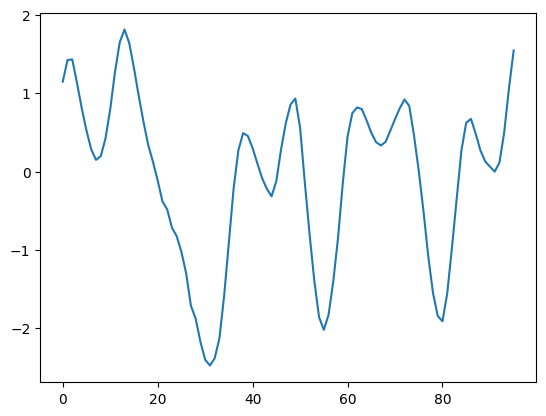

In [72]:
import matplotlib.pyplot as plt
plt.plot(el_nino_index_34)

In [73]:
normalized_index_nino34_rolling_mean = el_nino_index_34 / tos_el_nino_data.std()


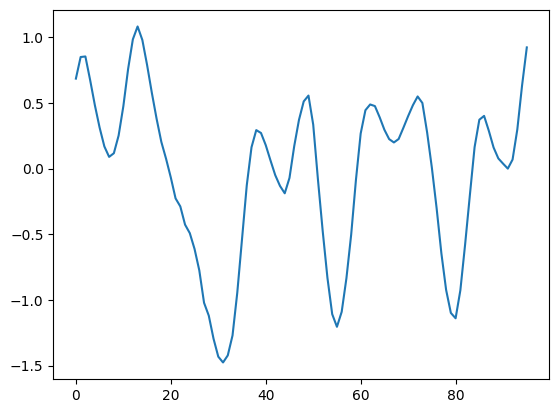

In [74]:
import matplotlib.pyplot as plt
plt.plot(normalized_index_nino34_rolling_mean)

In [94]:
normalized_index_nino34_rolling_mean >= 0.4

array([ True,  True,  True,  True,  True, False, False, False, False,
       False,  True,  True,  True,  True,  True,  True,  True, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False,  True,  True, False, False, False, False,
       False, False, False, False, False, False, False,  True,  True,
        True, False, False, False, False, False, False, False,  True,
        True,  True, False, False, False, False, False, False, False,
       False, False, False, False, False,  True, False, False, False,
       False, False, False, False,  True,  True])

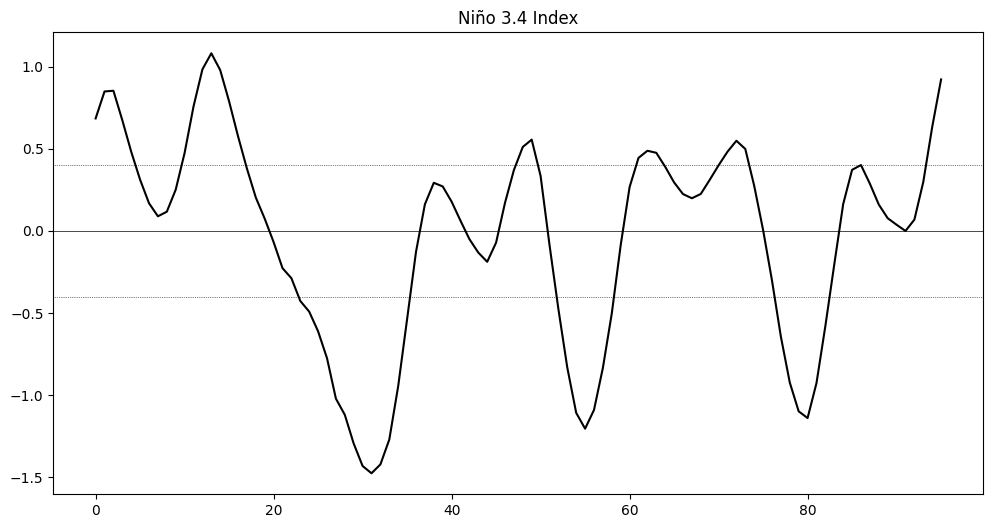

In [95]:
fig = plt.figure(figsize=(12, 6))

# plt.fill_between(
#     [x for x in range(96)],
#     normalized_index_nino34_rolling_mean >= 0.4,
#     0.4,
#     color='red',
#     alpha=0.9,
# )
# plt.fill_between(
#     normalized_index_nino34_rolling_mean,
#     normalized_index_nino34_rolling_mean.where(
#         normalized_index_nino34_rolling_mean <= -0.4
#     ).data,
#     -0.4,
#     color='blue',
#     alpha=0.9,
# )

plt.plot(normalized_index_nino34_rolling_mean,color='black')
plt.axhline(0, color='black', lw=0.5)
plt.axhline(0.4, color='black', linewidth=0.5, linestyle='dotted')
plt.axhline(-0.4, color='black', linewidth=0.5, linestyle='dotted')
plt.title('Niño 3.4 Index');


In [11]:
batch_sample_denormed['state_surface'][0,9,68:74,77:95] = 0

NameError: name 'batch_sample_denormed' is not defined

NameError: name 'batch_sample_denormed' is not defined

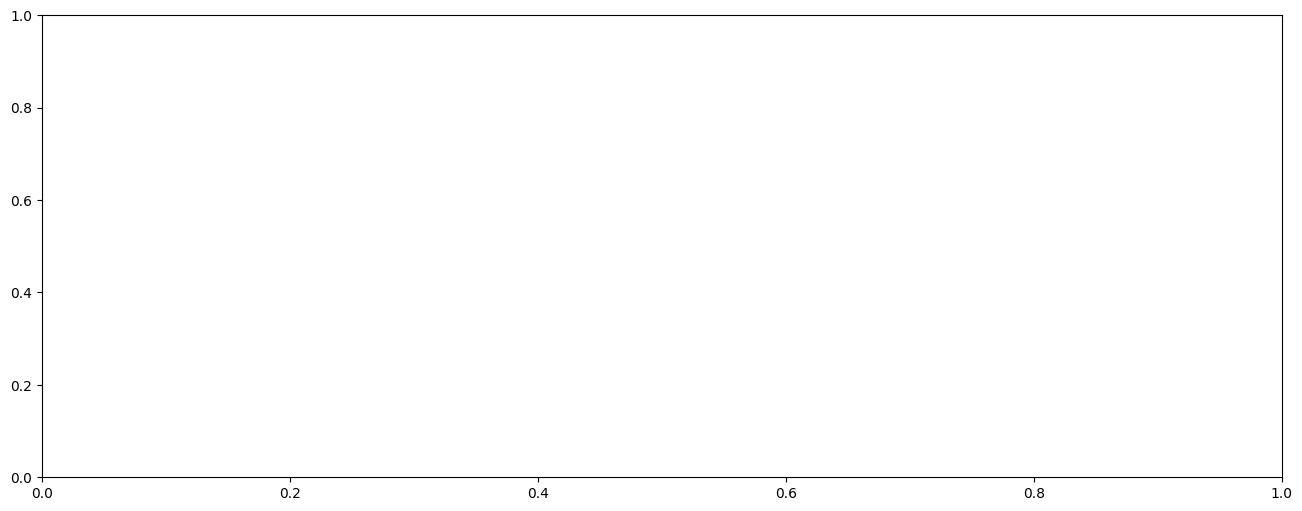

In [12]:
import matplotlib.pyplot as plt
shell = ds.isel(time=0)
fig, axes = plt.subplots(1,1, figsize=(16, 6))
shell['tas'].data = batch_sample_denormed['state_surface'][0,9]
shell['tas'].plot.pcolormesh(ax=axes,add_colorbar=False)